In [519]:
## Importing Library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
# Plot Style
sns.set_context("paper")
style.use('fivethirtyeight')

## Sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score,classification_report,accuracy_score,confusion_matrix,roc_auc_score,roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [520]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [521]:
df_train = pd.read_csv("train_s3TEQDk.csv")
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


# Inspect Dataframe

In [522]:
#database dimension
print("Database dimension     :",df_train.shape)
print("Database size          :",df_train.size)
print("Number of Row          :",len(df_train.index))
print("Number of Columns      :",len(df_train.columns))

Database dimension     : (245725, 11)
Database size          : 2702975
Number of Row          : 245725
Number of Columns      : 11


In [523]:
#info about the column types etc. 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


# Null Value Calculation

In [524]:
#Column wise Null Value calculate
#Column wise null values in train data set 
null_perc = pd.DataFrame(round((df_train.isnull().sum())*100/df_train.shape[0],2)).reset_index()
null_perc.columns = ['Column Name', 'Null Values Percentage']
null_value = pd.DataFrame(df_train.isnull().sum()).reset_index()
null_value.columns = ['Column Name', 'Null Values']
null_lead = pd.merge(null_value, null_perc, on='Column Name')
null_lead.sort_values("Null Values", ascending = False)

,Column Name,Null Values,Null Values Percentage
7,Credit_Product,29325,11.93
0,ID,0,0.00
1,Gender,0,0.00
2,Age,0,0.00
3,Region_Code,0,0.00
4,Occupation,0,0.00
5,Channel_Code,0,0.00
6,Vintage,0,0.00
8,Avg_Account_Balance,0,0.00
9,Is_Active,0,0.00


<AxesSubplot:>

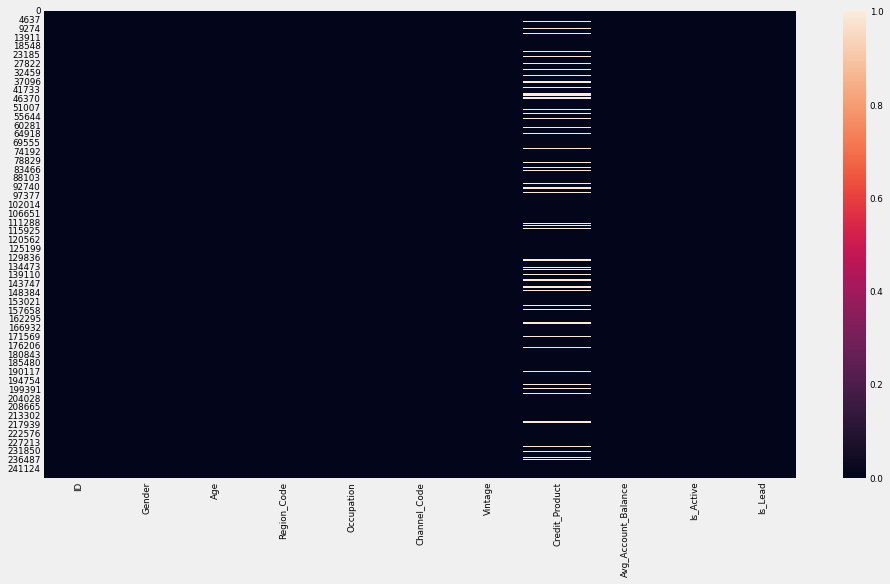

In [525]:
plt.figure(figsize=(15,8))
sns.heatmap(df_train.isnull())

# Duplicate Analysis

In [526]:
print("Total number of duplicate values in ID column :" , df_train.duplicated(subset = 'ID').sum())
print("Total number of duplicate values in Region_Code column :" , df_train.duplicated(subset = 'Region_Code').sum())
print("Total number of duplicate values in Channel_Code column :" , df_train.duplicated(subset = 'Channel_Code').sum())


Total number of duplicate values in ID column : 0
Total number of duplicate values in Region_Code column : 245690
Total number of duplicate values in Channel_Code column : 245721


# Data Cleaning

In [527]:
cols_to_drop=['ID']
## Dropping the unnecessary columns
df_train.drop(cols_to_drop,axis=1,inplace=True)

In [528]:
df_train

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...
245720,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,Female,28,RG273,Salaried,X1,31,No,407504,No,0


# Segregating Categorical & Numerical Values

In [529]:
categorical_col=df_train.select_dtypes(exclude=['number'])
numerical_col=df_train.select_dtypes(include=['number'])

# Categorical Column Analysis


In [530]:
categorical_col

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,Female,RG268,Other,X3,No,No
1,Female,RG277,Salaried,X1,No,No
2,Female,RG268,Self_Employed,X3,No,Yes
3,Male,RG270,Salaried,X1,No,No
4,Female,RG282,Salaried,X1,No,No
...,...,...,...,...,...,...
245720,Male,RG284,Self_Employed,X3,NaN,No
245721,Male,RG268,Salaried,X1,No,Yes
245722,Female,RG281,Salaried,X1,No,No
245723,Female,RG273,Salaried,X1,No,No


In [531]:
def Cat_info(df,categorical_column):
    df_result=pd.DataFrame(columns=["columns","values","unique_values","null_values","null_percent"])
    
    df_temp=pd.DataFrame()
    for value in categorical_column:
        df_temp['columns']=[value]
        df_temp['values']=[df[value].unique()]
        df_temp["unique_values"]=df[value].nunique()
        df_temp["null_values"] = df[value].isna().sum()
        df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
        df_result = df_result.append(df_temp)
    df_result.sort_values("null_values", ascending =False, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [532]:
df_cat = Cat_info(df_train, categorical_col)
df_cat

,values,unique_values,null_values,null_percent
columns,,,,
Credit_Product,"[No, nan, Yes]",2,29325,11.9
Gender,"[Female, Male]",2,0,0.0
Region_Code,"[RG268, RG277, RG270, RG282, RG261, RG265, RG2...",35,0,0.0
Occupation,"[Other, Salaried, Self_Employed, Entrepreneur]",4,0,0.0
Channel_Code,"[X3, X1, X2, X4]",4,0,0.0
Is_Active,"[No, Yes]",2,0,0.0


In [533]:
df_train.replace(np.nan,'unknown',inplace=True)

In [534]:
df_train['Credit_Product'].unique()

array(['No', 'unknown', 'Yes'], dtype=object)

In [535]:
df_train.isnull().sum()

Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

# Numerical Columns Null Value Treatment

In [536]:
# Checking unique values and null values for the categorical columns
def Num_info(df, numeric_column):
    df_result = pd.DataFrame(columns=["columns","null_values","null_percent","Skewness"])
    
    df_temp=pd.DataFrame()
    for value in numeric_column:
        df_temp["columns"] = [value]
        df_temp["Skewness"] = df[value].skew()
        df_temp["null_values"] = df[value].isna().sum()
        df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
        df_result = df_result.append(df_temp)
    
    df_result.sort_values("null_values", ascending =False, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [537]:
df_num = Num_info(df_train,numerical_col)
df_num

,null_values,null_percent,Skewness
columns,,,
Age,0,0.0,0.618992
Vintage,0,0.0,0.790189
Avg_Account_Balance,0,0.0,2.968727
Is_Lead,0,0.0,1.235596


<AxesSubplot:xlabel='Age'>

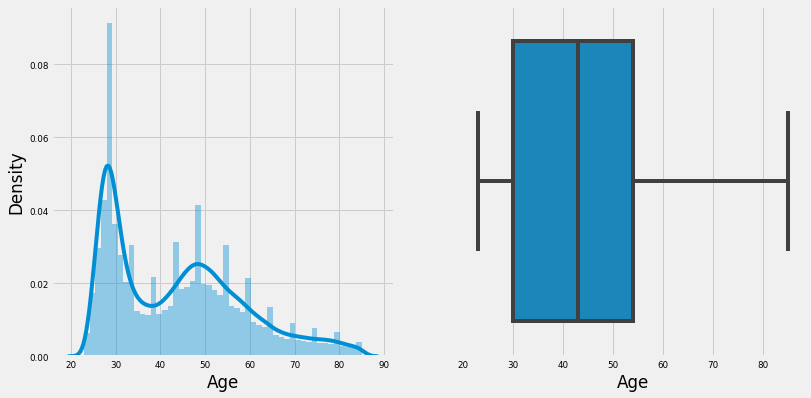

In [538]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(lead['Age'])
plt.subplot(1,2,2)
sns.boxplot(lead['Age'])

<AxesSubplot:xlabel='Vintage'>

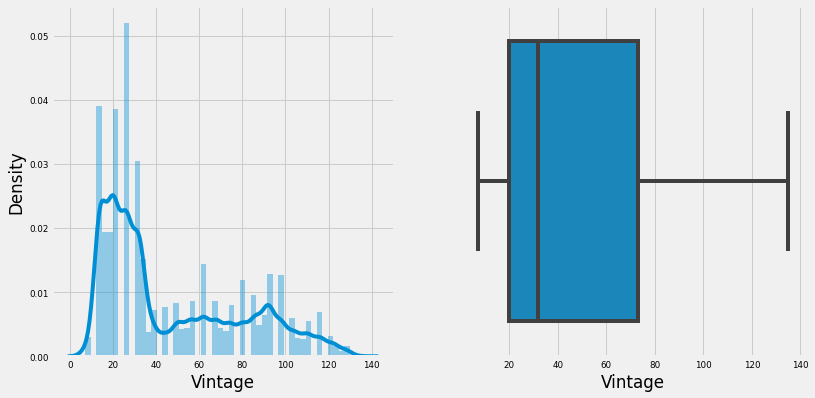

In [539]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(lead['Vintage'])
plt.subplot(1,2,2)
sns.boxplot(lead['Vintage'])

<AxesSubplot:xlabel='Avg_Account_Balance'>

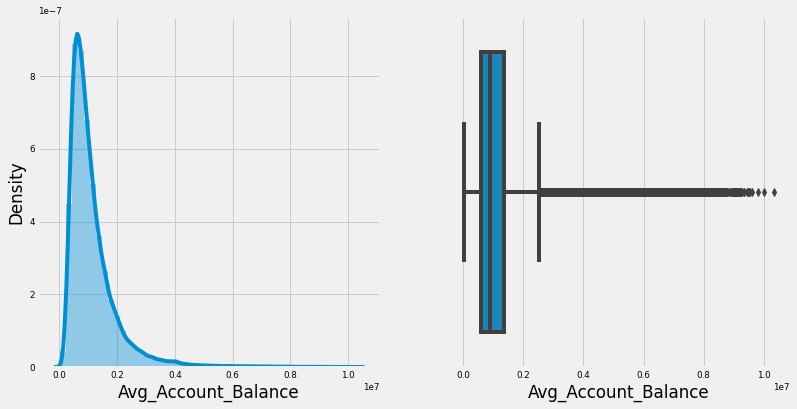

In [540]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(lead['Avg_Account_Balance'])
plt.subplot(1,2,2)
sns.boxplot(lead['Avg_Account_Balance'])

# 5. Exploratory Data Analysis

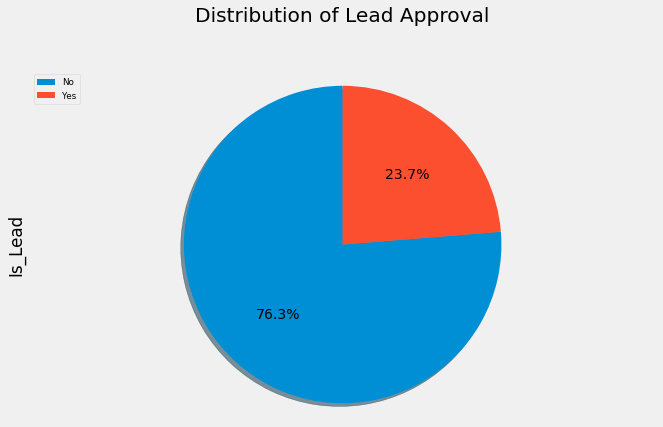

In [541]:
labels = 'No','Yes'
lead['Is_Lead'].astype(str).value_counts().plot(kind='pie',
                            figsize=(10, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,                                
                            )

plt.title('Distribution of Lead Approval', y=1.12) 
plt.axis('equal') 
# add legend
plt.legend(labels=labels, loc='upper left') 
 # show plot
plt.show()

# Data Preparation

Convert Binary Categories

In [542]:
categorical_col

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,Female,RG268,Other,X3,No,No
1,Female,RG277,Salaried,X1,No,No
2,Female,RG268,Self_Employed,X3,No,Yes
3,Male,RG270,Salaried,X1,No,No
4,Female,RG282,Salaried,X1,No,No
...,...,...,...,...,...,...
245720,Male,RG284,Self_Employed,X3,NaN,No
245721,Male,RG268,Salaried,X1,No,Yes
245722,Female,RG281,Salaried,X1,No,No
245723,Female,RG273,Salaried,X1,No,No


# Label Encoding

In [543]:
le=LabelEncoder()
for col in categorical_col.columns:
         df_train[col]=le.fit_transform(df_train[col])

In [544]:
df_train

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,18,1,2,43,0,1045696,0,0
1,0,30,27,2,0,32,0,581988,0,0
2,0,56,18,3,2,26,0,1484315,1,0
3,1,34,20,2,0,19,0,470454,0,0
4,0,30,32,2,0,33,0,886787,0,0
...,...,...,...,...,...,...,...,...,...,...
245720,1,51,34,3,2,109,2,1925586,0,0
245721,1,27,18,2,0,15,0,862952,1,0
245722,0,26,31,2,0,13,0,670659,0,0
245723,0,28,23,2,0,31,0,407504,0,0


# Train - Test Split

In [545]:
# target variable
Y = df_train['Is_Lead']
X = df_train.drop(['Is_Lead'], axis=1)


print(Y.value_counts())
print(X.shape)
print(Y.shape)

0    187437
1     58288
Name: Is_Lead, dtype: int64
(245725, 9)
(245725,)


# Model Function

In [546]:
 def best_model(clf,X,Y):  
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.20,stratify=Y,random_state=42)
    clf.fit(x_train,y_train)
    print("Training Accuracy:",clf.score(x_train,y_train))
    print("Testing Accuracy:",clf.score(x_test,y_test))
    pred=clf.predict(x_test)
    print("Accuracy Score:",accuracy_score(y_test,pred))
    print("Mean Accuracy:",cross_val_score(clf,X,Y,scoring='roc_auc',cv=5).mean())
    print("Roc Auc Score:",roc_auc_score(y_test,pred))
    print("Precsion Score:",precision_score(y_test,pred))
    print("Recall Score:",recall_score(y_test,pred))
    print("F_1 Score:",f1_score(y_test,pred))


    print("Classification Report \n",classification_report(y_test,pred))
    print('Confusion Matrix',confusion_matrix(y_test,pred))
    prob=clf.predict_proba(x_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_test,prob,pos_label=True)

    #plotting the graph for area under curve for representing accuracy of data
    plt.plot([0,1],[1,0],'g--')
    plt.plot(Fpr,Tpr)
    plt.xlabel('False_Positive_Rate')
    plt.ylabel('True_Positive_Rate')
    plt.title("Logistic Regression")
    plt.show()

# Training Model Without Standard Scaling

Training Accuracy: 0.7627937735273171
Testing Accuracy: 0.7627835995523451
Accuracy Score: 0.7627835995523451
Mean Accuracy: 0.44742658075559627
Roc Auc Score: 0.5
Precsion Score: 0.0
Recall Score: 0.0
F_1 Score: 0.0
Classification Report 
               precision    recall  f1-score   support

           0       0.76      1.00      0.87     37487
           1       0.00      0.00      0.00     11658

    accuracy                           0.76     49145
   macro avg       0.38      0.50      0.43     49145
weighted avg       0.58      0.76      0.66     49145

Confusion Matrix [[37487     0]
 [11658     0]]


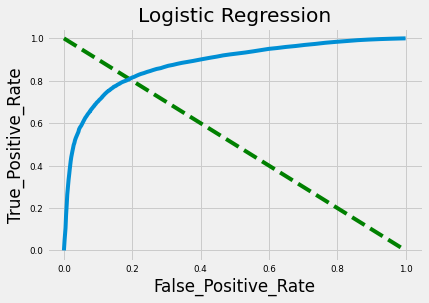

In [547]:
lr=LogisticRegression()
best_model(lr,X,Y)

# Training Model With Statndard Scaling

In [548]:
X.head(2)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,73,18,1,2,43,0,1045696,0
1,0,30,27,2,0,32,0,581988,0


In [549]:
Y.head(2)

0    0
1    0
Name: Is_Lead, dtype: int64

In [550]:
ss=StandardScaler()
xs=pd.DataFrame(ss.fit_transform(X),columns=X.columns)
xs.head(2)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,-1.096931,1.965365,-0.172389,-1.292279,1.239925,-0.122373,-0.761626,-0.096968,-0.796872
1,-1.096931,-0.934429,0.655830,-0.120975,-1.020375,-0.462372,-0.761626,-0.640630,-0.796872


Training Accuracy: 0.8474158103571066
Testing Accuracy: 0.846657849221691
Accuracy Score: 0.846657849221691
Mean Accuracy: 0.8530399033822729
Roc Auc Score: 0.727291209222674
Precsion Score: 0.773342175066313
Recall Score: 0.5001715560130383
F_1 Score: 0.6074591103239921
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     37487
           1       0.77      0.50      0.61     11658

    accuracy                           0.85     49145
   macro avg       0.82      0.73      0.76     49145
weighted avg       0.84      0.85      0.83     49145

Confusion Matrix [[35778  1709]
 [ 5827  5831]]


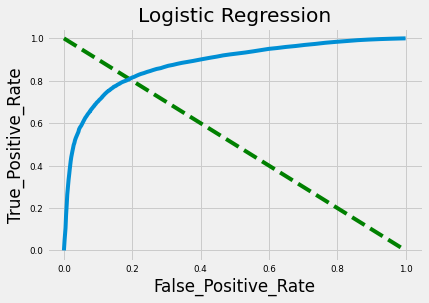

In [551]:
best_model(lr,xs,Y)

# Apply Under Sampling(Manually)

In [552]:
# To balance the dataset , we will apply undersampling method
from sklearn.utils import resample
# separate the minority and majority classes
df_majority = df_train[df_train['Is_Lead']==0]
df_minority = df_train[df_train['Is_Lead']==1]

print(" The majority class values are", len(df_majority))
print(" The minority class values are", len(df_minority))
print(" The ratio of both classes are", len(df_majority)/len(df_minority))


 The majority class values are 187437
 The minority class values are 58288
 The ratio of both classes are 3.215704776283283


In [553]:
# undersample majority class
df_majority_undersampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=0)
# combine minority class with oversampled majority class
df_undersampled = pd.concat([df_minority, df_majority_undersampled])

df_undersampled['Is_Lead'].value_counts()
df_2=df_undersampled

# display new class value counts
print(" The undersamples class values count is:", len(df_undersampled))
print(" The ratio of both classes are", len(df_undersampled[df_undersampled["Is_Lead"]==0])/len(df_undersampled[df_undersampled["Is_Lead"]==1]))

 The undersamples class values count is: 116576
 The ratio of both classes are 1.0


In [554]:
df_2.shape

(116576, 10)

In [555]:
# target variable
yu = df_2['Is_Lead']
xu = df_2.drop(['Is_Lead'], axis=1)


In [556]:
xu=pd.DataFrame(ss.fit_transform(xu),columns=xu.columns)

Training Accuracy: 0.7880549002787904
Testing Accuracy: 0.7845256476239493
Accuracy Score: 0.7845256476239493
Mean Accuracy: 0.8529191012498576
Roc Auc Score: 0.784525647623949
Precsion Score: 0.7915275092283354
Recall Score: 0.7725167267112713
F_1 Score: 0.7819065810036466
Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     11658
           1       0.79      0.77      0.78     11658

    accuracy                           0.78     23316
   macro avg       0.78      0.78      0.78     23316
weighted avg       0.78      0.78      0.78     23316

Confusion Matrix [[9286 2372]
 [2652 9006]]


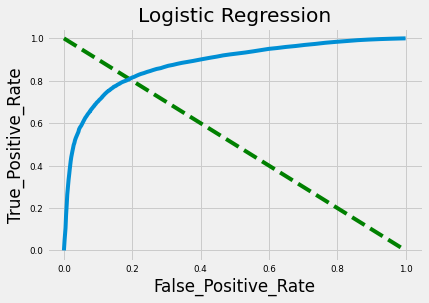

In [557]:
best_model(lr,xu,yu)

# Apply Over Sampling(Manually)

In [558]:
# undersample majority class
df_minority_undersampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
# combine minority class with oversampled majority class
df_oversampled = pd.concat([df_majority, df_minority_undersampled])

df_oversampled['Is_Lead'].value_counts()
df_3=df_oversampled

# display new class value counts
print(" The oversamples class values count is:", len(df_oversampled))
print(" The ratio of both classes are", len(df_undersampled[df_undersampled["Is_Lead"]==0])/len(df_undersampled[df_undersampled["Is_Lead"]==1]))

 The oversamples class values count is: 374874
 The ratio of both classes are 1.0


In [559]:
df_3['Is_Lead'].value_counts()

0    187437
1    187437
Name: Is_Lead, dtype: int64

In [560]:
df_train['Is_Lead'].value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [561]:
df_3.shape,df_train.shape

((374874, 10), (245725, 10))

In [562]:
# target variable
yo = df_3['Is_Lead']
xo = df_3.drop(['Is_Lead'], axis=1)


Training Accuracy: 0.7892990640182195
Testing Accuracy: 0.7870223407802601
Accuracy Score: 0.7870223407802601
Mean Accuracy: 0.8540779542452747
Roc Auc Score: 0.7870222268887046
Precsion Score: 0.792004776508264
Recall Score: 0.7784832075119374
F_1 Score: 0.7851857830871471
Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     37488
           1       0.79      0.78      0.79     37487

    accuracy                           0.79     74975
   macro avg       0.79      0.79      0.79     74975
weighted avg       0.79      0.79      0.79     74975

Confusion Matrix [[29824  7664]
 [ 8304 29183]]


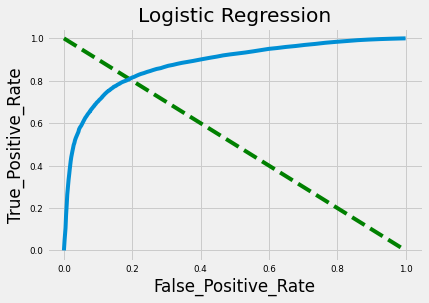

In [563]:
xo=pd.DataFrame(ss.fit_transform(xo),columns=xo.columns)
best_model(lr,xo,yo)

# Different Oversampling,Undersampling and Combine oversampling methods

## Tips

#1-- 1st approach should be to split data in X and Y.

#2-- If requried do scaling on whole data.

#3-- Then apply sampling on scaled data.

# Balance data with the imbalanced-learn python module

In [564]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, Y)

print('original dataset shape:',Y.shape)
print("Original Dataset Shape: \n", Y.value_counts())
print('Resample dataset shape', y_rus.shape)
print("Original Resample Shape: \n", y_rus.value_counts())

original dataset shape: (245725,)
Original Dataset Shape: 
 0    187437
1     58288
Name: Is_Lead, dtype: int64
Resample dataset shape (116576,)
Original Resample Shape: 
 0    58288
1    58288
Name: Is_Lead, dtype: int64


Training Accuracy: 0.7887733218957752
Testing Accuracy: 0.7808800823468862
Accuracy Score: 0.7808800823468862
Mean Accuracy: 0.8527086155303166
Roc Auc Score: 0.7808800823468863
Precsion Score: 0.7844670315350534
Recall Score: 0.7745753988677303
F_1 Score: 0.779489835556131
Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.79      0.78     11658
           1       0.78      0.77      0.78     11658

    accuracy                           0.78     23316
   macro avg       0.78      0.78      0.78     23316
weighted avg       0.78      0.78      0.78     23316

Confusion Matrix [[9177 2481]
 [2628 9030]]


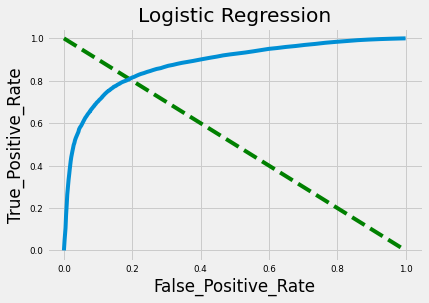

In [565]:
x_rus=pd.DataFrame(ss.fit_transform(x_rus),columns=x_rus.columns)
best_model(lr,x_rus,y_rus)

# Random over-sampling with imblearn

In [566]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(X, Y)

print('original dataset shape:',Y.shape)
print("Original Dataset Shape: \n", Y.value_counts())
print('Resample dataset shape', y_ros.shape)
print("Original Resample Shape: \n", y_ros.value_counts())

original dataset shape: (245725,)
Original Dataset Shape: 
 0    187437
1     58288
Name: Is_Lead, dtype: int64
Resample dataset shape (374874,)
Original Resample Shape: 
 0    187437
1    187437
Name: Is_Lead, dtype: int64


Training Accuracy: 0.7877785521125446
Testing Accuracy: 0.7879426475491831
Accuracy Score: 0.7879426475491831
Mean Accuracy: 0.8529660471477266
Roc Auc Score: 0.7879425622991044
Precsion Score: 0.7916666666666666
Recall Score: 0.7815509376583882
F_1 Score: 0.7865762802872674
Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.79      0.79     37488
           1       0.79      0.78      0.79     37487

    accuracy                           0.79     74975
   macro avg       0.79      0.79      0.79     74975
weighted avg       0.79      0.79      0.79     74975

Confusion Matrix [[29778  7710]
 [ 8189 29298]]


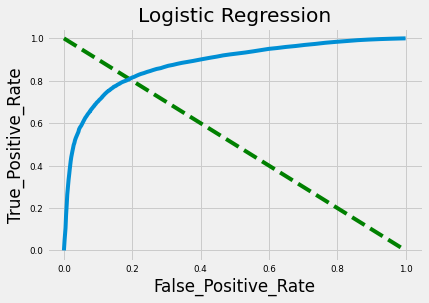

In [567]:
x_ros=pd.DataFrame(ss.fit_transform(x_ros),columns=x_rus.columns)
best_model(lr,x_ros,y_ros)

# Synthetic Minority Oversampling Technique (SMOTE)

In [568]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, Y)

print('Original dataset shape', Y.shape)
print('Resample dataset shape', y_smote.shape)
print('Resample dataset shape', y_smote.value_counts())

Original dataset shape (245725,)
Resample dataset shape (374874,)
Resample dataset shape 0    187437
1    187437
Name: Is_Lead, dtype: int64


Training Accuracy: 0.7522499241411276
Testing Accuracy: 0.7510103367789263
Accuracy Score: 0.7510103367789263
Mean Accuracy: 0.8275712143272951
Roc Auc Score: 0.7510101695120577
Precsion Score: 0.7574629928585109
Recall Score: 0.7384693360364927
F_1 Score: 0.7478455844611936
Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     37488
           1       0.76      0.74      0.75     37487

    accuracy                           0.75     74975
   macro avg       0.75      0.75      0.75     74975
weighted avg       0.75      0.75      0.75     74975

Confusion Matrix [[28624  8864]
 [ 9804 27683]]


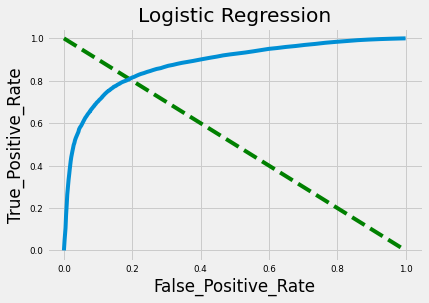

In [569]:
x_smote=pd.DataFrame(ss.fit_transform(x_smote),columns=x_smote.columns)
best_model(lr,x_smote,y_smote)

# Combining OverSampling and Undersampling by Imblearn

In [570]:
from imblearn.combine import SMOTETomek
smt=SMOTETomek()
x_tom,y_tom=smt.fit_resample(X,Y)
print('Original dataset shape', Y.shape)
print('Resample dataset shape', y_tom.shape)
print('Resample dataset shape', y_tom.value_counts())

Original dataset shape (245725,)
Resample dataset shape (340170,)
Resample dataset shape 0    170085
1    170085
Name: Is_Lead, dtype: int64


Training Accuracy: 0.7593115207102331
Testing Accuracy: 0.7583120204603581
Accuracy Score: 0.7583120204603581
Mean Accuracy: 0.8357614771603249
Roc Auc Score: 0.7583120204603581
Precsion Score: 0.7649879372738239
Recall Score: 0.745715377605315
F_1 Score: 0.7552287241168852
Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.77      0.76     34017
           1       0.76      0.75      0.76     34017

    accuracy                           0.76     68034
   macro avg       0.76      0.76      0.76     68034
weighted avg       0.76      0.76      0.76     68034

Confusion Matrix [[26224  7793]
 [ 8650 25367]]


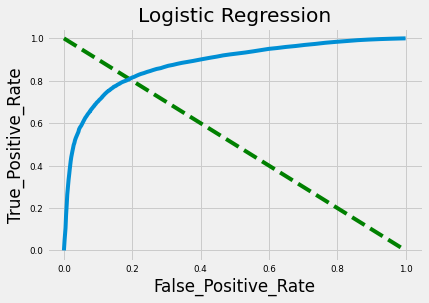

In [571]:
x_tom=pd.DataFrame(ss.fit_transform(x_tom),columns=x_tom.columns)
best_model(lr,x_tom,y_tom)

# SMOTEENN

In [582]:
## 1stly ovresample then standard scaling
from imblearn.combine import SMOTEENN
teen=SMOTEENN()
x_een,y_een=smt.fit_resample(X,Y)
print('Original dataset shape', Y.shape)
print('Resample dataset shape', y_een.shape)
print('Resample dataset shape', y_een.value_counts())

Original dataset shape (245725,)
Resample dataset shape (340338,)
Resample dataset shape 0    170169
1    170169
Name: Is_Lead, dtype: int64


Training Accuracy: 0.7583024203915231
Testing Accuracy: 0.7600340835634953
Accuracy Score: 0.7600340835634953
Mean Accuracy: 0.8351385793701966
Roc Auc Score: 0.7600340835634952
Precsion Score: 0.7653036752802925
Recall Score: 0.7501028383381324
F_1 Score: 0.7576270180436847
Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.77      0.76     34034
           1       0.77      0.75      0.76     34034

    accuracy                           0.76     68068
   macro avg       0.76      0.76      0.76     68068
weighted avg       0.76      0.76      0.76     68068

Confusion Matrix [[26205  7829]
 [ 8505 25529]]


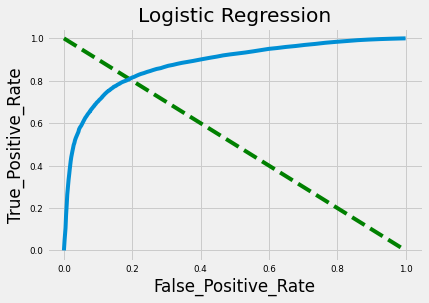

In [585]:
dt_pt = pd.DataFrame(st.fit_transform(x_een),columns=x_een.columns)
dt_pt

best_model(lr,dt_pt,y_een)

In [586]:
## 1st Standard Scaling then SMOTEENN
x_ss=pd.DataFrame(ss.fit_transform(X),columns=X.columns)
from imblearn.combine import SMOTEENN
teen=SMOTEENN()
x_teen,y_teen=smt.fit_resample(x_ss,Y)
print('Original dataset shape', Y.shape)
print('Resample dataset shape', y_teen.shape)
print('Resample dataset shape', y_teen.value_counts())
#best_model(lr,x_teen,y_teen)


Original dataset shape (245725,)
Resample dataset shape (360156,)
Resample dataset shape 0    180078
1    180078
Name: Is_Lead, dtype: int64


Training Accuracy: 0.8001103691466175
Testing Accuracy: 0.7981036206130608
Accuracy Score: 0.7981036206130608
Mean Accuracy: 0.865689844566311
Roc Auc Score: 0.798103620613061
Precsion Score: 0.8036254630807952
Recall Score: 0.7890104398045313
F_1 Score: 0.7962508931448505
Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     36016
           1       0.80      0.79      0.80     36016

    accuracy                           0.80     72032
   macro avg       0.80      0.80      0.80     72032
weighted avg       0.80      0.80      0.80     72032

Confusion Matrix [[29072  6944]
 [ 7599 28417]]


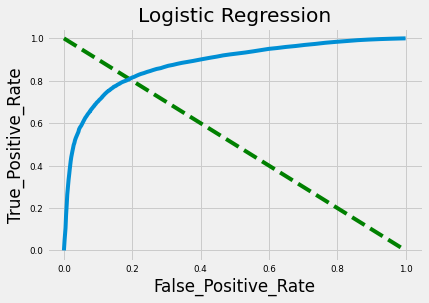

In [587]:
best_model(lr,x_teen,y_teen)

# Tried Random Forest Classifier.................

Training Accuracy: 0.9999791756327137
Testing Accuracy: 0.9082768769435806
Accuracy Score: 0.9082768769435806
Mean Accuracy: 0.9651893108239152
Roc Auc Score: 0.9082768769435806
Precsion Score: 0.9122718479266549
Recall Score: 0.9034318080852954
F_1 Score: 0.9078303084413321
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.91      0.91     36016
           1       0.91      0.90      0.91     36016

    accuracy                           0.91     72032
   macro avg       0.91      0.91      0.91     72032
weighted avg       0.91      0.91      0.91     72032

Confusion Matrix [[32887  3129]
 [ 3478 32538]]


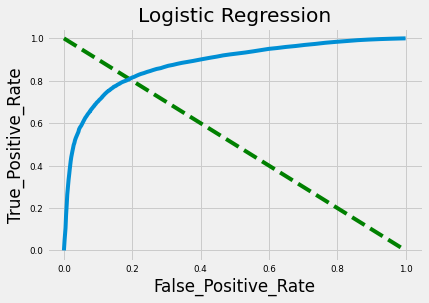

In [588]:
rf=RandomForestClassifier()
best_model(rf,x_teen,y_teen)

In [649]:
df_train['Probablity']=rf.predict_proba(x_ss)[:,1]

In [650]:
df_train[df_train['Is_Lead']==1]

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Probablity
6,1,62,32,1,2,20,2,1056750,1,1,0.97
15,1,33,18,3,1,69,2,517063,1,1,0.87
16,0,46,18,1,2,97,1,2282502,0,1,0.88
17,0,59,33,1,2,15,1,2384692,0,1,0.75
20,1,44,19,3,1,19,1,1001650,0,1,0.27
...,...,...,...,...,...,...,...,...,...,...,...
245697,1,43,7,2,0,50,0,551203,1,1,0.84
245699,1,53,4,1,1,19,2,1141825,1,1,0.98
245709,1,36,34,3,2,15,1,608110,1,1,0.31
245713,0,41,27,3,1,13,1,898170,1,1,0.94


In [651]:
df_train[df_train['Is_Lead']==0]

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Probablity
0,0,73,18,1,2,43,0,1045696,0,0,0.03
1,0,30,27,2,0,32,0,581988,0,0,0.00
2,0,56,18,3,2,26,0,1484315,1,0,0.01
3,1,34,20,2,0,19,0,470454,0,0,0.09
4,0,30,32,2,0,33,0,886787,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
245720,1,51,34,3,2,109,2,1925586,0,0,0.94
245721,1,27,18,2,0,15,0,862952,1,0,0.01
245722,0,26,31,2,0,13,0,670659,0,0,0.02
245723,0,28,23,2,0,31,0,407504,0,0,0.00


In [662]:
df_train.to_csv("result_training.csv")

In [640]:
62572+16401

78973

In [652]:
df_train.shape

(245725, 11)

In [653]:
df_train[df_train['Is_Lead']==0].shape

(187437, 11)

In [654]:
df_train[df_train['Is_Lead']==1].shape

(58288, 11)

In [655]:
df_train[(df_train['Is_Lead']==1) & (df_train['Probablity']>0.5)].shape

(53050, 11)

In [656]:
df_train[(df_train['Is_Lead']==1) & (df_train['Probablity']<0.5)].shape

(5161, 11)

In [657]:
df_train[(df_train['Is_Lead']==0) & (df_train['Probablity']<0.5)].shape

(182236, 11)

In [658]:
df_train[(df_train['Is_Lead']==0) & (df_train['Probablity']>0.5)].shape

(5009, 11)

In [659]:
df_train[df_train['Probablity']>.5].shape

(58059, 11)

In [660]:
df_train[df_train['Probablity']<.5].shape

(187397, 11)

# Loading the test Model

In [611]:
df_test=pd.read_csv("test_mSzZ8RL.csv")
df_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [612]:
## Applying same operations

df_test.replace(np.nan,'unknown',inplace=True)

le=LabelEncoder()
for col in categorical_col.columns:
         df_test[col]=le.fit_transform(df_test[col])
df_test1=df_test.drop(['ID'],axis=1)
x_test=pd.DataFrame(ss.fit_transform(df_test1),columns=df_test1.columns)
x_test.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0.908299,-0.999878,-1.451764,-1.294862,-1.019283,-0.676804,0.668140,-0.452333,-0.806682
1,0.908299,-0.058563,-0.167798,-1.294862,0.112272,0.066841,2.101608,-0.240878,-0.806682
2,0.908299,-0.865404,0.015626,-0.121541,-1.019283,-1.017641,-0.765327,-1.060037,-0.806682
3,0.908299,-0.999878,0.199050,-1.294862,-1.019283,-0.428922,-0.765327,-0.307219,-0.806682
4,-1.100959,-0.999878,0.015626,-1.294862,-1.019283,-0.862715,-0.765327,-0.550781,-0.806682


In [670]:
lead_proba=rf.predict_proba(x_test)[:,1]
prediction=rf.predict(x_test)
final=pd.DataFrame()
final['ID']=df_test['ID']
final['Probablity']=lead_proba
final['Lead_prediction']=prediction

final.head()

,ID,Probablity,Lead_prediction
0,VBENBARO,0.15,0
1,CCMEWNKY,1.00,1
2,VK3KGA9M,0.49,0
3,TT8RPZVC,0.45,0
4,SHQZEYTZ,0.59,1


In [672]:
final.to_csv("result_testing.csv")

In [618]:
#Saving the model :
    
import joblib
#save the model as a pickle in a file 
joblib.dump('Lead_1','rf_model.pkl')

['rf_model.pkl']